# Analyzing Performance Between the Primary and Secondary Drivers of F1 Teams
*Unit 4 Project*

### Setup

The code below is just to import the data, and parse it so that we can easily use it in our code.

In [21]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [22]:
# Read the dataset from GitHub

f1_data = pd.read_csv("https://raw.githubusercontent.com/blortle-dev/data-science-lasa/refs/heads/main/resources/modern_constructor_results.csv")

Next, I'll make a graph of the data, to help us better visualize it.

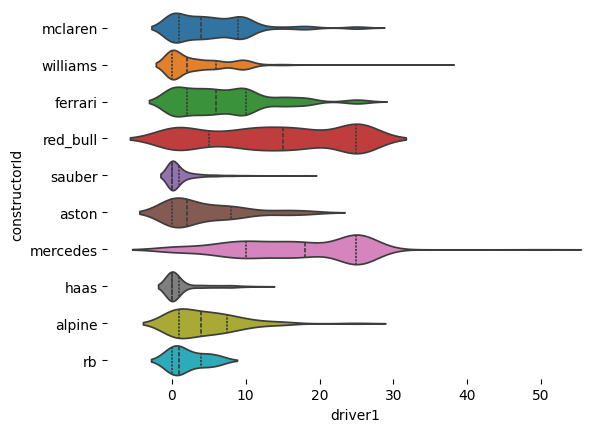

In [23]:
# Graph the data

# Driver 1 data
sns.violinplot(f1_data, x='driver1', y='constructorId', inner='quart',hue='constructorId')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

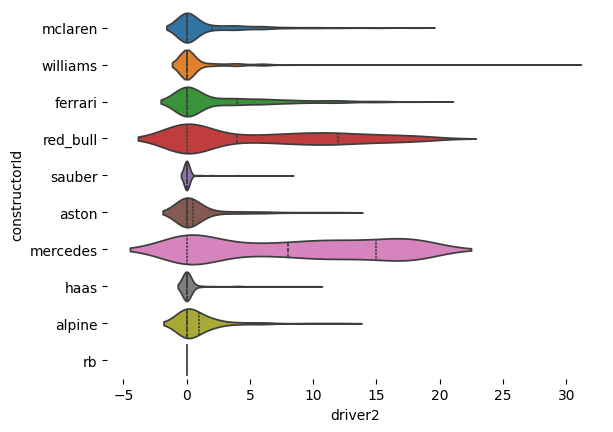

In [24]:
# Driver 2 data
sns.violinplot(f1_data, x='driver2', y='constructorId', inner='quart',hue='constructorId')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

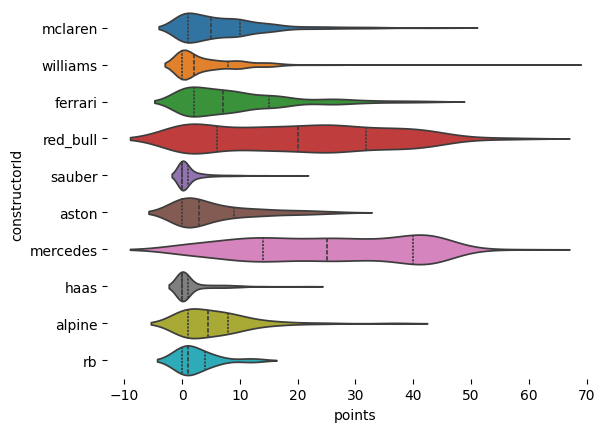

In [25]:
# Overall data
sns.violinplot(f1_data, x='points', y='constructorId', inner='quart',hue='constructorId')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

This graph shows the distribution between how many points each (current) constructor has scored in any given race weekend. The maximum a team could score in a weekend is 52 points, with the following split:
- 25pts - 1st
- 18pts - 2nd
- 1pt - Fastest lap
- 8pts - Sprint win (if Sprint weekend)

### Preparing the Data

We'll follow the instructions from the notes to prepare our model. First, we'll get the difference in points between driver1 and driver2, and add this to our data.

In [26]:
#element wise subtraction
diff_TminusE = f1_data.driver1 - f1_data.driver2
#adds a column called 'diff_TminusE' as the fifth column of cs_data
f1_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [27]:
# Here, we'll print out the data w/ the new column:

f1_data

,constructorResultsId,raceId,constructorId,points,diff_TminusE,status,driver1,driver2
0,1,18,mclaren,14.0,6.0,\N,10.0,4.0
1,3,18,williams,9.0,3.0,\N,6.0,3.0
2,6,18,ferrari,1.0,1.0,\N,1.0,0.0
3,9,18,red_bull,0.0,0.0,\N,0.0,0.0
4,12,19,ferrari,10.0,10.0,\N,10.0,0.0
...,...,...,...,...,...,...,...,...
4209,17005,1132,aston,10.0,2.0,\N,6.0,4.0
4210,17006,1132,williams,2.0,2.0,\N,2.0,0.0
4211,17007,1132,rb,1.0,1.0,\N,1.0,0.0
4212,17008,1132,sauber,0.0,0.0,\N,0.0,0.0


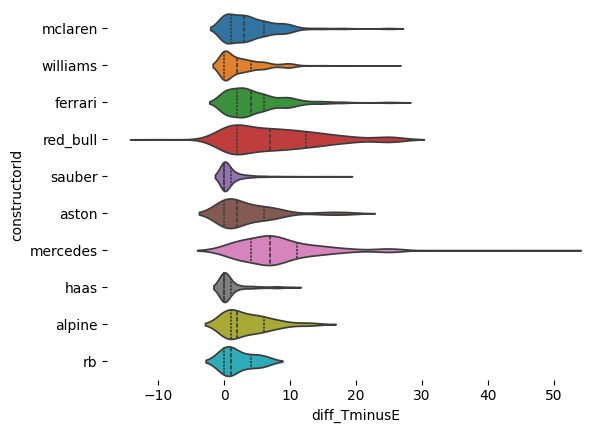

In [28]:
# And, here's a visual of the above table:

#visualize difference in driver points gap for a weekend
sns.violinplot(f1_data, x='diff_TminusE', y='constructorId', inner='quart',hue='constructorId')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

### Preparing the Model

Here, we'll get everything ready for our model.

In [29]:
aa_encode = pd.Categorical(f1_data['constructorId'])
aa_encode

['mclaren', 'williams', 'ferrari', 'red_bull', 'ferrari', ..., 'aston', 'williams', 'rb', 'sauber', 'alpine']
Length: 4214
Categories (10, object): ['alpine', 'aston', 'ferrari', 'haas', ..., 'rb', 'red_bull', 'sauber',
                          'williams']

In [30]:
aa_idx = aa_encode.codes
aa_idx

array([4, 9, 2, ..., 6, 8, 0], dtype=int8)

In [31]:
aa_coords = {"constructorId": aa_encode.categories}
aa_coords

{'constructorId': Index(['alpine', 'aston', 'ferrari', 'haas', 'mclaren', 'mercedes', 'rb',
        'red_bull', 'sauber', 'williams'],
       dtype='object')}

### The Non-Heirarchical Model

The code below is adapted from the [Unit 4 Notes AK](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Unit4/Unit4NotesAK.ipynb).

I've modified the `sigma` values for both μ and σ, as the data here is likely to be quite narrow.

In [32]:
with pm.Model(coords=aa_coords) as cs_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.Normal('μ', mu=0, sigma=5,
                  dims="constructorId")
    σ = pm.HalfNormal('σ', sigma=5,
                      dims="constructorId")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=f1_data.diff_TminusE)

    #cs for chemshift, nh for nonheirarchical
    idata_cs_nh = pm.sample()

/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1278: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()

Output()

And, here's the graph of the distribution:

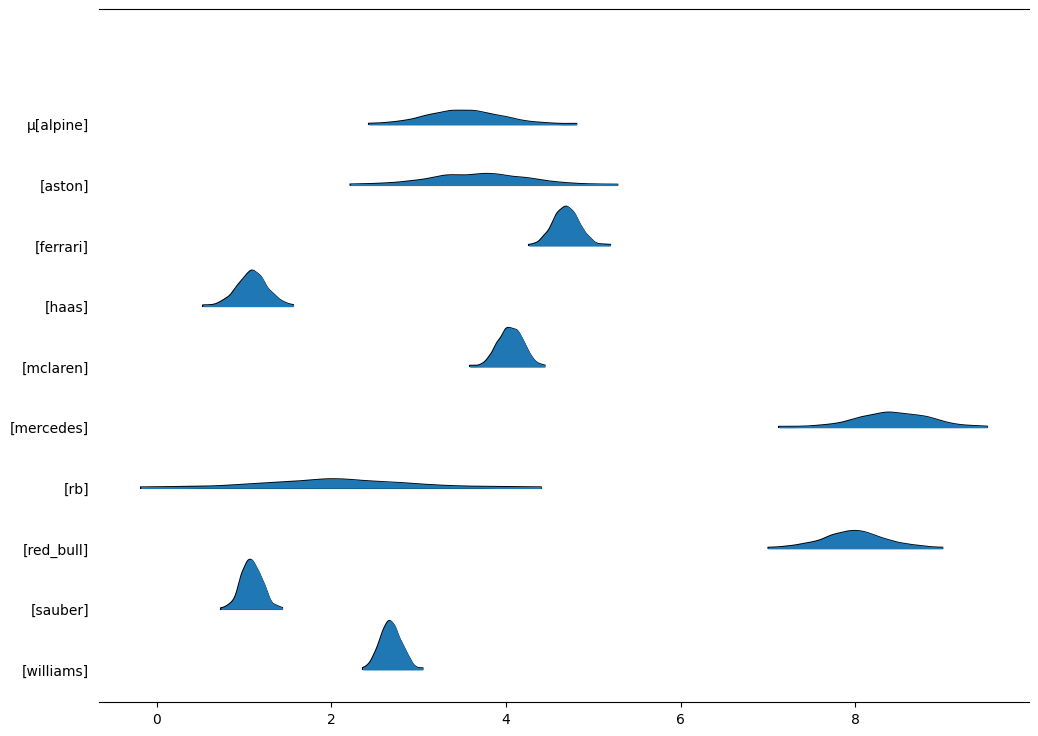

In [33]:
#plots the middle 99.7% of each amino acids' posterior distribution of the mean
#why 99.7%? No reason, just seems like a good number to me.
#Feel free to pick your own hdi %; the default is 94%.
axes = az.plot_forest(idata_cs_nh, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

Here, I've adapted the Hierarchical model from the notes as well. Due to the nature of Formula 1, I've modified the hyperpriors and prior to be narrower, just like in the other model.

In [34]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 5)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 5)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "constructorId")

    σ = pm.HalfNormal('σ', sigma = 5,
                      dims = "constructorId")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = f1_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1278: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()

Output()

And, here's our final graph of the posteriors:

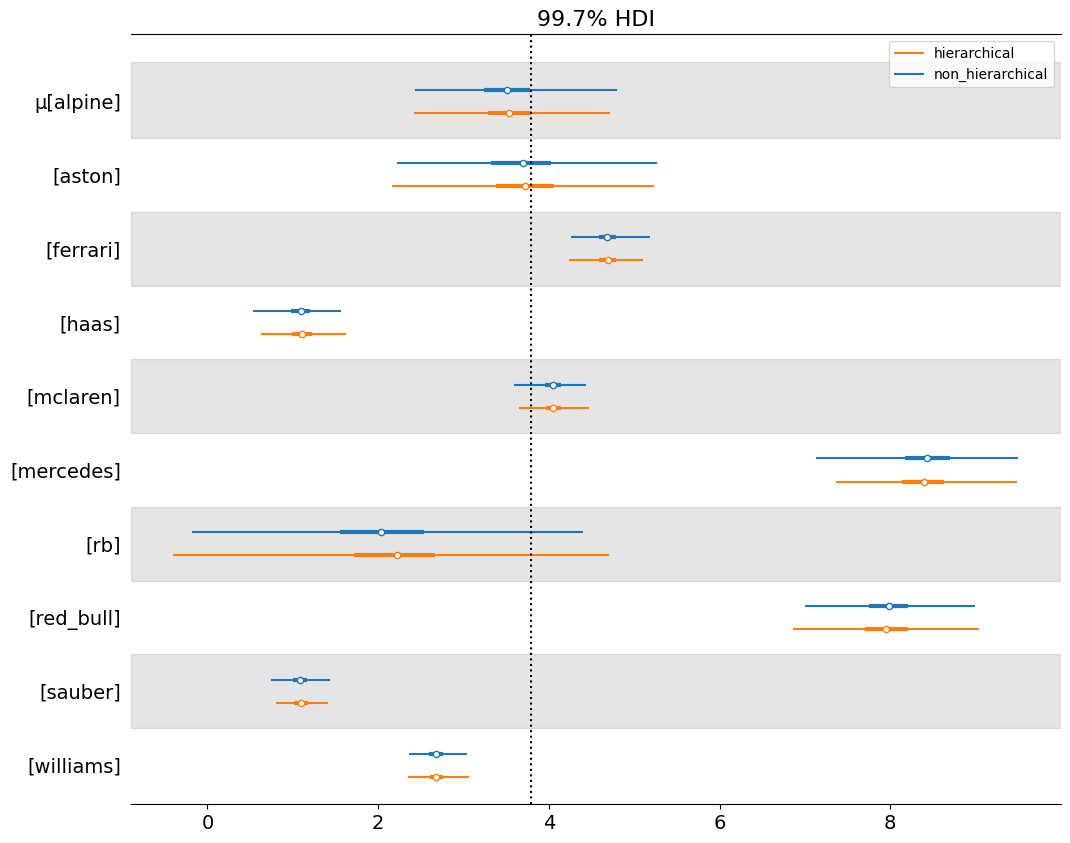

In [35]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_nh, idata_cs_h], kind="forestplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

### Analysis

This graph shows the likely distribution of the difference in points between the primary and secondary drivers for different Formula 1 teams. It's important to keep in mind that this project is using data from as long as the team has been around, so teams like Ferrari (joined f1 in 1950) will have much more data than teams like VCARB (referred to as rb, joined in 2024)

As we can see in the graph, Sauber and Haas are pretty close in terms of lowest predicted points difference. This makes a lot of since, as Sauber doesn't score points too often (none this year, as of now), and the two Haas cars tend to finish a race within a couple positions of the other.

The most consistent teams are either Sauber or Williams, which we can see in the graph by them having the shortest lines. Both of these teams are considered 'backmarkers,' where points are rare, with usually only one driver finishing in the points.

The least consistent teams are quite obvious, those being VCARB (rb) and Aston Martin. This is visible because they have the longest lines, meaning they have the most variation when it comes to a difference of points between the drivers.

The highest predicted points difference is between Red Bull Racing and Mercedes. This makes a lot of sense, as both teams tend to have one driver perform really well, while the other falls behind or retires. (Max & Perez, Russell & Hamilton).

The data in this model is a bit outdated as well, being about 4 months old, around the British Grand Prix. Newer data would likely change the graph quite a bit, as there have been some mid-season driver changes.

### Full Model

Here's all the code in one block:<br />
*(no comments)*

In [35]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

f1_data = pd.read_csv("https://raw.githubusercontent.com/blortle-dev/data-science-lasa/refs/heads/main/resources/modern_constructor_results.csv")

sns.violinplot(f1_data, x='driver1', y='constructorId', inner='quart',hue='constructorId')
sns.despine(top=True, right=True, bottom=True, left=True)

sns.violinplot(f1_data, x='driver2', y='constructorId', inner='quart',hue='constructorId')
sns.despine(top=True, right=True, bottom=True, left=True)

sns.violinplot(f1_data, x='points', y='constructorId', inner='quart',hue='constructorId')
sns.despine(top=True, right=True, bottom=True, left=True)

diff_TminusE = f1_data.driver1 - f1_data.driver2
f1_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

sns.violinplot(f1_data, x='diff_TminusE', y='constructorId', inner='quart',hue='constructorId')
sns.despine(top=True, right=True, bottom=True, left=True)

aa_encode = pd.Categorical(f1_data['constructorId'])

aa_idx = aa_encode.codes

aa_coords = {"constructorId": aa_encode.categories}

with pm.Model(coords=aa_coords) as cs_nh_model:
    μ = pm.Normal('μ', mu=0, sigma=5,
                  dims="constructorId")
    σ = pm.HalfNormal('σ', sigma=5,
                      dims="constructorId")
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=f1_data.diff_TminusE)
    idata_cs_nh = pm.sample()

axes = az.plot_forest(idata_cs_nh, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

with pm.Model(coords=aa_coords) as cs_h_model:
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 5)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 5)
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "constructorId")
    σ = pm.HalfNormal('σ', sigma = 5,
                      dims = "constructorId")
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = f1_data.diff_TminusE)
    idata_cs_h = pm.sample()

axes = az.plot_forest([idata_cs_nh, idata_cs_h], kind="forestplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");